In [1]:
from csv import DictReader

with open('terpines.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    rows = [r for r in reader]
csv_file.close()

exp_ysi = [float(r['Exp. YSI']) for r in rows]
smiles = [r['SMILES'] for r in rows]

In [2]:
from ecnet.datasets import QSPRDataset, load_ysi, load_cn, load_lhv

terpines = QSPRDataset(smiles, exp_ysi, backend='alvadesc')

_ysi_smiles, _ysi = load_ysi()
ysi_smiles, ysi = [], []
for i in range(len(_ysi_smiles)):
    if _ysi[i][0] < 300:
        ysi_smiles.append(_ysi_smiles[i])
        ysi.append(_ysi[i])
cn_smiles, cn = load_cn()
lhv_smiles, lhv = load_lhv()

In [3]:
from sklearn.model_selection import train_test_split

ysi_smiles_train, _, ysi_train, _ = train_test_split(ysi_smiles, ysi, test_size=0.2, random_state=24)
cn_smiles_train, _, cn_train, _ = train_test_split(cn_smiles, cn, test_size=0.2, random_state=24)
lhv_smiles_train, _, lhv_train, _ = train_test_split(lhv_smiles, lhv, test_size=0.2, random_state=24)
ds_ysi = QSPRDataset(ysi_smiles_train, ysi_train, backend='alvadesc')
ds_cn = QSPRDataset(cn_smiles_train, cn_train, backend='alvadesc')
ds_lhv = QSPRDataset(lhv_smiles_train, lhv_train, backend='alvadesc')

In [4]:
from sklearn.decomposition import PCA
import torch

pca_ysi = PCA(n_components=len(ds_ysi))
pca_ysi.fit(ds_ysi.desc_vals.detach().numpy())
terpines_ysi = torch.tensor(pca_ysi.transform(terpines.desc_vals.detach().numpy())).type(torch.float32)

pca_cn = PCA(n_components=len(ds_cn))
pca_cn.fit(ds_cn.desc_vals.detach().numpy())
terpines_cn = torch.tensor(pca_cn.transform(terpines.desc_vals.detach().numpy())).type(torch.float32)

pca_lhv = PCA(n_components=len(ds_lhv))
pca_lhv.fit(ds_lhv.desc_vals.detach().numpy())
terpines_lhv = torch.tensor(pca_lhv.transform(terpines.desc_vals.detach().numpy())).type(torch.float32)

In [5]:
from ecnet.model import load_model

model_ysi = load_model('models/ysi_0.pt')
model_cn = load_model('models/cn_0.pt')
model_lhv = load_model('models/lhv_0.pt')
pred_ysi = model_ysi(terpines_ysi).detach().numpy()
pred_cn = model_cn(terpines_cn).detach().numpy()
pred_lhv = model_lhv(terpines_lhv).detach().numpy()

In [6]:
from csv import DictWriter

for i, row in enumerate(rows):
    row['Pred. YSI'] = pred_ysi[i][0]
    row['Pred. CN'] = pred_cn[i][0]
    row['Pred. LHV'] = pred_lhv[i][0]

headers = rows[0].keys()

with open('terpine_predictions.csv', 'w', encoding='utf8') as csv_file:
    writer = DictWriter(csv_file, headers, delimiter=',', lineterminator='\n')
    writer.writeheader()
    writer.writerows(rows)
csv_file.close()

In [7]:
from sklearn.metrics import median_absolute_error, r2_score

print(median_absolute_error(exp_ysi, pred_ysi))
print(r2_score(exp_ysi, pred_ysi))

21.516004943847655
0.3682782383455482


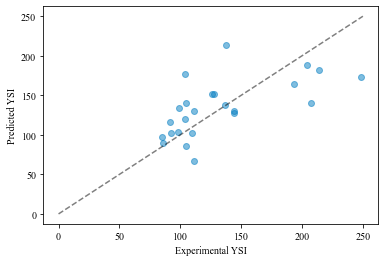

In [8]:
from matplotlib import pyplot as plt

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Experimental YSI')
plt.ylabel('Predicted YSI')
plt.plot([0, 250], [0, 250], 'k--', alpha=0.5)
plt.scatter(exp_ysi, pred_ysi, alpha=0.5, color=(0, 114/235, 178/235))
plt.show()